In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar src al path
sys.path.append(os.path.abspath('../src'))

from data_gen import generate_dataset
from text_cleaner import normalize_text
from model_utils import train_classic_model, get_transformer_embeddings, train_transformer_head

# Configuración visual
sns.set_theme(style="whitegrid")
%matplotlib inline

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


Generando 5,000 tickets sintéticos...
Dataset Shape: (5000, 4)

Ejemplos de Datos:


,receipt_text,clean_text,category
2738,JABON ZOTE ROSA,jabon zote rosa,LIMPIEZA
4662,ARROZ VERDE VLL 1KG,arroz verde vll 1kg,ABARROTES
1843,CERVEZA MODE ESPECIAL BOT,cerveza mode especial bot,BEBIDAS
175,G BONAFONT 1 L,g bonafont 1 l,BEBIDAS
2609,LECHE ALPURA DESL,leche alpura desl,LACTEOS


/tmp/ipykernel_32645/109524810.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['category'], palette='viridis')


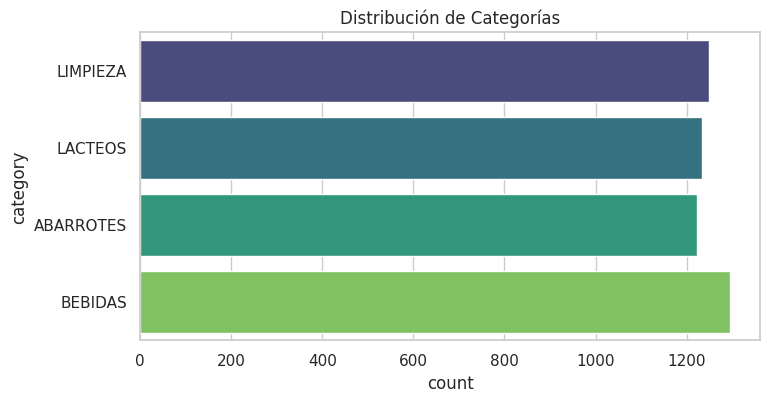

In [4]:
# 1. Generar Datos Sintéticos "Sucios"
print("Generando 5,000 tickets sintéticos...")
df = generate_dataset(n_samples=5000)

# 2. Preprocesamiento
df['clean_text'] = df['receipt_text'].apply(normalize_text)

print(f"Dataset Shape: {df.shape}")
print("\nEjemplos de Datos:")
display(df[['receipt_text', 'clean_text', 'category']].sample(5))

# Ver balanceo de clases
plt.figure(figsize=(8,4))
sns.countplot(y=df['category'], palette='viridis')
plt.title("Distribución de Categorías")
plt.show()

In [5]:
# --- EXPERIMENTO 1: Enfoque Clásico (TF-IDF + Random Forest) ---
model_classic, metrics_classic = train_classic_model(df, 'clean_text', 'category')

print(f"\nAccuracy Clásico: {metrics_classic['accuracy']:.2%}")

>>> Entrenando Modelo Clásico (TF-IDF + Random Forest)...

Accuracy Clásico: 100.00%


In [6]:
# --- EXPERIMENTO 2: Enfoque Moderno (DistilBERT Embeddings) ---
# Paso A: Convertir texto a vectores densos (Embeddings)
embeddings = get_transformer_embeddings(df['clean_text'].tolist())

# Paso B: Entrenar clasificador sobre los vectores
model_dl, metrics_dl = train_transformer_head(embeddings, df['category'])

print(f"\nAccuracy Deep Learning: {metrics_dl['accuracy']:.2%}")

>>> Generando Embeddings con distilbert-base-uncased...


100%|██████████| 157/157 [01:07<00:00,  2.34it/s]


>>> Entrenando Clasificador sobre Embeddings...

Accuracy Deep Learning: 100.00%


/tmp/ipykernel_32645/4038173376.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy', data=results, ax=ax[0], palette='Blues')


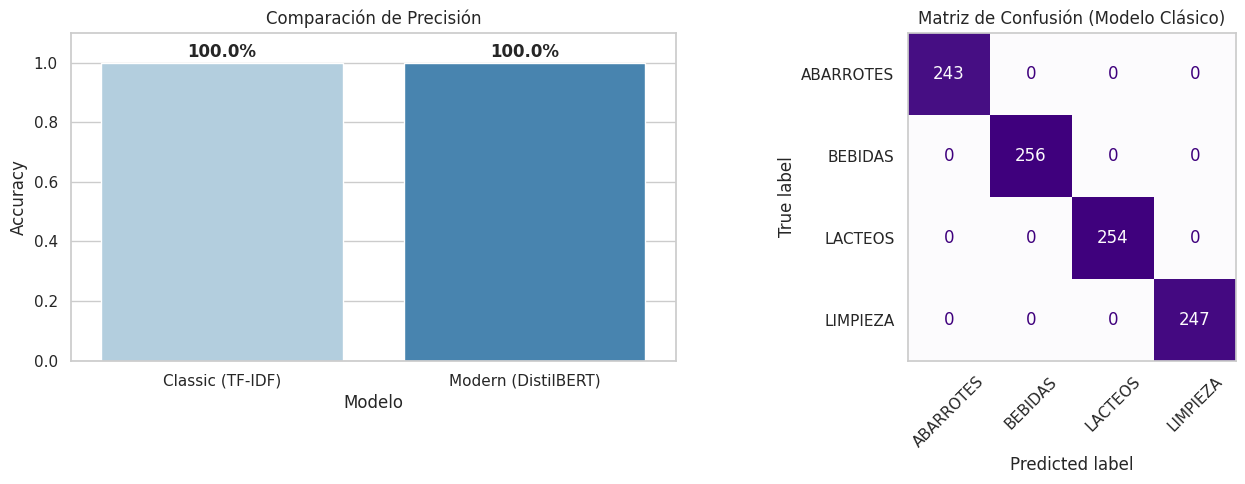

In [9]:
# Análisis de Trade-offs
results = pd.DataFrame({
    'Modelo': ['Classic (TF-IDF)', 'Modern (DistilBERT)'],
    'Accuracy': [metrics_classic['accuracy'], metrics_dl['accuracy']],
    'Complexity': ['Low (CPU)', 'High (Need GPU)'] 
})

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Precisión
sns.barplot(x='Modelo', y='Accuracy', data=results, ax=ax[0], palette='Blues')
ax[0].set_ylim(0, 1.1)
ax[0].set_title('Comparación de Precisión')
for i, v in enumerate(results['Accuracy']):
    ax[0].text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')

# Gráfico 2: Matriz de Confusión
from sklearn.metrics import ConfusionMatrixDisplay

# --- CORRECCIÓN AQUÍ ---
# No llamamos a train_classic_model de nuevo.
# Extraemos los datos de prueba directamente del diccionario 'metrics_classic'
X_test_plot = metrics_classic['X_test']
y_test_plot = metrics_classic['y_test']

ConfusionMatrixDisplay.from_estimator(
    model_classic, 
    X_test_plot, 
    y_test_plot, 
    ax=ax[1], 
    cmap='Purples', 
    colorbar=False,
    xticks_rotation=45
)
ax[1].set_title('Matriz de Confusión (Modelo Clásico)')
ax[1].grid(False)

plt.tight_layout()
plt.show()

In [8]:
def predict_product(text):
    """Función para probar el modelo manualmente"""
    clean = normalize_text(text)
    pred = model_classic.predict([clean])[0]
    prob = model_classic.predict_proba([clean]).max()
    return f"Input: '{text}' -> Pred: {pred} ({prob:.1%})"

# Probemos con casos difíciles (Errores de dedo, abreviaturas)
test_cases = [
    "LECH LALA ENTE 1L",
    "JABN ZOT ROS 400G",
    "COCA COL 600ML",
    "SOPA NISI CAMRN"
]

print("--- DEMOSTRACIÓN DE INFERENCIA ---")
for t in test_cases:
    print(predict_product(t))

--- DEMOSTRACIÓN DE INFERENCIA ---
Input: 'LECH LALA ENTE 1L' -> Pred: LACTEOS (89.0%)
Input: 'JABN ZOT ROS 400G' -> Pred: BEBIDAS (50.0%)
Input: 'COCA COL 600ML' -> Pred: BEBIDAS (62.0%)
Input: 'SOPA NISI CAMRN' -> Pred: ABARROTES (64.0%)
